# Preliminaries

In [1]:
import numpy as np
from numpy import random as rd
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [10, 6]

# Supplied code:

from numpy import pi, sqrt, log, exp

#
# Normal cumulative distribution function, with extension
# for complex argument with small imaginary component
#


def norm_cdf(x):
    if not isinstance(x, np.ndarray):
        xr = x.real
        xi = x.imag
        if abs(xi) > 1.0e-10:
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if abs(xi) > 0:
            ncf = ncf + 1.0j * xi * norm.pdf(xr)
    else:
        xr = np.real(x)
        xi = np.imag(x)
        if any(abs(xi) > 1.0e-10):
            raise ValueError("imag(x) too large in norm_cdf(x)")

        ncf = norm.cdf(xr)
        if any(abs(xi) > 0):
            ncf = ncf + 1.0j * xi * norm.pdf(xr)

    return ncf


# V = european_call(r,sigma,T,S,K,opt)
#
# Black-Scholes European call option solution
# as defined in equation (3.17) on page 48 of
# The Mathematics of Financial Derivatives
# by Wilmott, Howison and Dewynne
#
# r     - interest rate
# sigma - volatility
# T     - time interval
# S     - asset value(s)  (float or flattened numpy array)
# K     - strike price(s) (float or flattened numpy array)
# opt   - 'value', 'delta', 'gamma' or 'vega'
# V     - option value(s) (float or flattened numpy array)
#


def european_call(r, sigma, T, S, K, opt):

    S = S + 1.0e-100  # avoids problems with S=0
    K = K + 1.0e-100  # avoids problems with K=0

    d1 = (log(S) - log(K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S) - log(K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))

    if opt == "value":
        V = S * norm_cdf(d1) - exp(-r * T) * K * norm_cdf(d2)
    elif opt == "delta":
        V = norm_cdf(d1)
    elif opt == "gamma":
        V = exp(-0.5 * d1 ** 2) / (sigma * sqrt(2 * pi * T) * S)
    elif opt == "vega":
        V = S * (exp(-0.5 * d1 ** 2) / sqrt(2 * pi)) * (sqrt(T) - d1 / sigma) - exp(
            -r * T
        ) * K * (exp(-0.5 * d2 ** 2) / sqrt(2 * pi)) * (-sqrt(T) - d2 / sigma)

    else:
        raise ValueError(
            'invalid value for opt -- must be "value", "delta", "gamma", "vega"'
        )

    return V

# Weak convergence

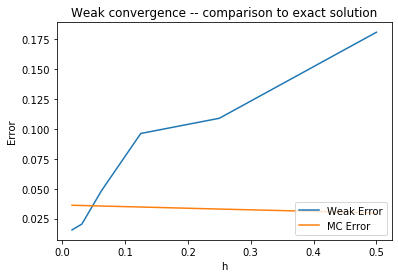

In [2]:
#
# Test weak convergence of Euler method
# for European call option
#
# Test problem:   dS   = r*S dt + sig*S dW
#

#
# problem parameters and exact solution
#

[r, sig, T, S0, K]   = [0.05, 0.5, 1, 100, 110] 

Ve  = european_call(r,sig,T,S0,K,'value')

#
# Monte Carlo simulation comparing to exact solution 
#

M  = 1e7   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err1, err2] = [np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 7):
    N = 2**p
    h = T/N

    [sum1, sum2] = [0, 0]
    

    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        S = S0*np.ones((1,m2))
        
        
        for n in range(1,N+1):
            dW = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW)   

        test = S-K
        P = exp(-r*T)*(abs(test) + test) / 2

        sum1 = sum1 + np.sum(P)
        sum2 = sum2 + np.sum(P**2)

    V  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))

    [hh, err1, err2] = [np.append(hh,h),np.append(err1,V-Ve),np.append(err2,3*sd)]
    
plt.plot(hh, np.abs(err1), label="Weak Error")
plt.plot(hh, err2, label="MC Error")
plt.title("Weak convergence -- comparison to exact solution")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

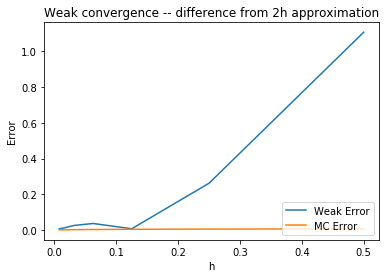

In [3]:
#
# Monte Carlo simulation comparing to 2h simulaton 
#

M  = 1e7   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err1, err2] = [np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 8):
    N = 2**p
    h = T/N

    [sum1, sum2] = [0, 0]
    

    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        [S, S2] = [S0*np.ones((1,m2)), S0*np.ones((1,m2))]
        
        
        for n in range(1,int(N/2+1)):
            dW1 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW1)
            dW2 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW2)
            
            S2  = S2*(1+r*2*h+sig*(dW1+dW2))
            
        [test1, test2] = [S-K, S2-K]
        P = exp(-r*T)*(abs(test1) + test1) / 2
        P2 = exp(-r*T)*(abs(test2) + test2) / 2

        sum1 = sum1 + np.sum(P-P2)
        sum2 = sum2 + np.sum((P-P2)**2)

    Vd  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))

    [hh, err1, err2] = [np.append(hh,h),np.append(err1,Vd),np.append(err2,3*sd)]
    
plt.plot(hh, np.abs(err1), label="Weak Error")
plt.plot(hh, err2, label="MC Error")
plt.title("Weak convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()

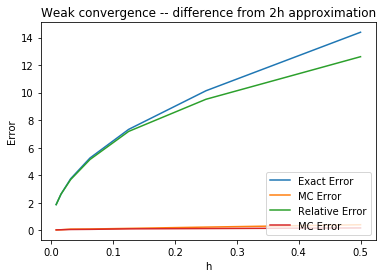

In [4]:
#
# Test strong convergence of Euler method
# for solving stochastic o.d.e.'s
#
# Test problem:   dS   = r*S dt + sig*S dW
# Exact solution: S(1) = S(0)*exp((lambda-0.5*sig^2)+sig*W(1))
#

#
# problem parameters
#

[r, sig, T, S0]   = [0.05, 0.5, 1, 100] 

#
# Monte Carlo simulation comparing to 2h simulation
#

M  = 1e5   # total number of Monte Carlo paths
M2 = 1e4   # number of paths at a time 

[hh, err1, err2, err3, err4] = [np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

for p in range(1, 8):
    N = 2**p
    h = T/N

    [sum1, sum2, sum3, sum4] = [0, 0, 0, 0]
    

    for m in np.linspace(1,(M/M2 -1) *M2 + 1,num = M//M2):
        
        m2 = int(np.min([M2, M-m+1]))
        [S, S2, W] = [S0*np.ones((1,m2)), S0*np.ones((1,m2)), 0]
        
        
        for n in range(1,N //2+1):
            dW1 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW1)
            dW2 = np.sqrt(h)*rd.randn(1,m2)
            S  = S*(1+r*h+sig*dW2)
            
            S2  = S2*(1+r*2*h+sig*(dW1+dW2))
            
            W = W + dW1 + dW2
            
        Se = S0*exp((r-0.5*sig**2)*T + sig*W)
        
        de1 = (Se-S)**2
        sum1 = sum1 + np.sum(de1)
        sum2 = sum2 + np.sum(de1**2)

        de1 = (S2-S)**2
        sum3 = sum3 + np.sum(de1)
        sum4 = sum4 + np.sum(de1**2)
        
        
    Vd  = sum1/M
    sd = np.sqrt((sum2/M - (sum1/M)**2)/(M-1))
    
    [hh, err1, err2] = [np.append(hh,h),np.append(err1,sqrt(Vd)),np.append(err2,0.5 *3*sd / sqrt(Vd))]
    
    Vd = sum3/M
    sd = np.sqrt((sum4/M - (sum3/M)**2)/(M-1))
    
    [err3, err4] = [np.append(err3,sqrt(Vd)),np.append(err4,0.5 *3*sd / sqrt(Vd))]

plt.plot(hh, np.abs(err1), label="Exact Error")
plt.plot(hh, err2, label="MC Error")
plt.plot(hh, np.abs(err3), label="Relative Error")
plt.plot(hh, err4, label="MC Error")
plt.title("Weak convergence -- difference from 2h approximation")
plt.xlabel("h")
plt.ylabel("Error")
plt.legend(loc="lower right")
plt.show()
